# Определение закономерностей, определяющих успешность игр

**Задача:** Выявить определяющие успешность игры закономерности и поcтроить прогноз на следующий (2017й) год.

**Исходные данные:** исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) собранные из открытых источников. 

<a id='content'></a>
## Оглавление 
[Предварительный анализ данных](#1)

[Исследовательский анализ данных](#2)
 - [Количество релизов по годам](#2-1)
 - [Количество релизов по платформам](#2-2)
 - [Анализ платформ лидеров продаж](#2-3)

[Портрет пользователя каждого региона](#3)
 - [Топ 5 платформ по регионам](#3-1)
 - [Топ 5 популярных жанров по регионам ](#3-2)
 - [Анализ связи рейтинга ESRB и продаж в регионах](#3-3)
 
[Проверка гипотез](#4)

[Вывод](#outcome)

<a id='1'></a>
## Предварительный анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import copy
from scipy import stats as st

In [2]:
# импорт данных
data = pd.read_csv('/datasets/games.csv')
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Описание данных:<br>
Имеются данные до 2016 года. Данные за 2016 год могут быть неполными.<br>
Name — название игры<br>
Platform — платформа<br>
Year_of_Release — год выпуска<br>
Genre — жанр игры<br>
NA_sales — продажи в Северной Америке (миллионы проданных копий)<br>
EU_sales — продажи в Европе (миллионы проданных копий)<br>
JP_sales — продажи в Японии (миллионы проданных копий)<br>
Other_sales — продажи в других странах (миллионы проданных копий)<br>
Critic_Score — оценка критиков (максимум 100)<br>
User_Score — оценка пользователей (максимум 10)<br>
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [3]:
# проверка типа данных и наличия пропущенных значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Пропущенные значения в столбцах: name, year_of_release, genre, critic_score, user_score, rating. Заполнять пропущенные значения не будем, т к у нас нет достаточной информации для восстановления. Возможно, пропуски появились из-за технической ошибки. Можно попробовать поговорить с коллегами, предоставившими данные

Поскольку у нас нет информации, по которой мы могли бы востановить рейтинг, наверное лучше выделить пропуски в отдельную группу

В столбце user_score тип данных подразумевается float, сейчас object

Названия столбцов нужно привести к одному регистру

In [4]:
# заполнение пропущенных значений в столце rating на 'WR' (without rating)
data['Rating'] = data['Rating'].fillna('WR')

0         E
1        WR
2         E
3         E
4        WR
         ..
16710    WR
16711    WR
16712    WR
16713    WR
16714    WR
Name: Rating, Length: 16715, dtype: object

In [5]:
# приведение названий столбцов к одному регистру
data.columns = data.columns.str.lower()

In [6]:
# проверка на дубликаты
data.duplicated().sum()

0

дубликатов нет

In [7]:
# изучение столбца user_score. Использование метода .to_numeric привело в ошибке
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Есть пропущенные значения nan, есть значения 'tbd'. Абривиатура tbd при оценке рейтинга расшифровывается как To Be Decided. 

Изучим количество рейтинга tbd в разные года

In [8]:
data[data['user_score'] == 'tbd'].groupby('year_of_release').count()['user_score']

year_of_release
1997.0      1
1999.0      8
2000.0     43
2001.0     82
2002.0    192
2003.0     95
2004.0    107
2005.0    121
2006.0    124
2007.0    192
2008.0    326
2009.0    405
2010.0    331
2011.0    217
2012.0     24
2013.0     15
2014.0     21
2015.0     38
2016.0     34
Name: user_score, dtype: int64

Оценка tbd присутствует практически во все года. Возможно, user_score для этих игр или в результате так и не был определен, или в таблице можно восстановить tbd в user-score из других источников. Стоит поговорить с коллегами, которые выдали данные

Для дальнейшего исследования приведем значения столбца user_score к типу float

In [9]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

In [10]:
# суммарные продажи в регионах
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


[К оглавлению](#content)

<a id='2'></a>
## Исследовательский анализ данных

[К оглавлению](#content)

<a id='2-1'></a>
### Количество релизов по годам

In [11]:
# сколько игр выпускалось в разные годы
data.groupby('year_of_release')['year_of_release'].count()

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

Text(0.5, 1.0, 'Amount of games by years')

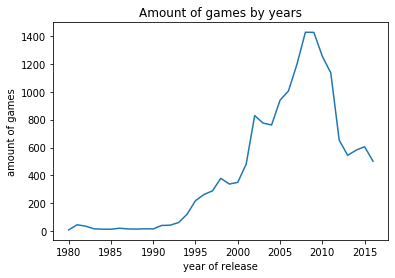

In [12]:
# сколько игр выпускалось в разные годы
fig, ax = plt.subplots() 
ax.plot(data.groupby('year_of_release')['year_of_release'].count().index, 
        data.groupby('year_of_release')['year_of_release'].count())
ax.set_xlabel('year of release')
ax.set_ylabel('amount of games')
ax.set_title("Amount of games by years")

До 1994 года тренд боковой: выпускалось относительно мало и примерно одинаковое количество игр в год. После 1994 количество выпускаемых игр в год начинает расти и достигает максимума в 2008-2009 годах. Далее наблюдается отрицательный тренд

[К оглавлению](#content)

<a id='2-2'></a>
### Количество релизов по платформам

In [13]:
# количество релизов по платформам
popular_platform_amount = data.groupby('platform')['platform'].count().sort_values(ascending = False).head(10)
popular_platform_amount

platform
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
Name: platform, dtype: int64

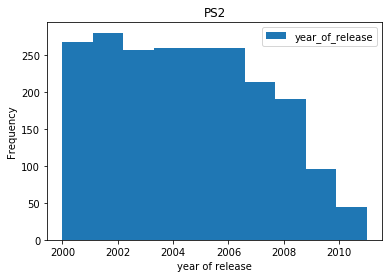

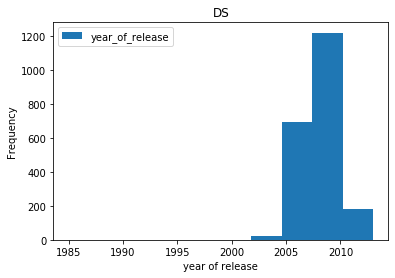

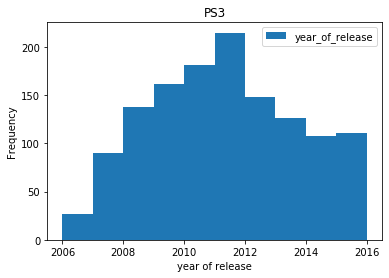

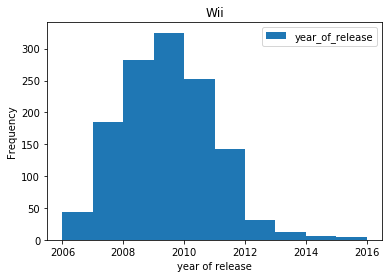

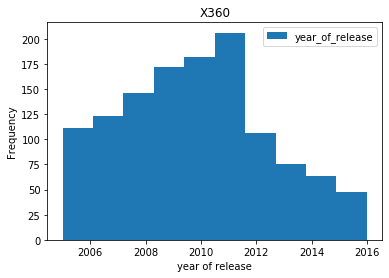

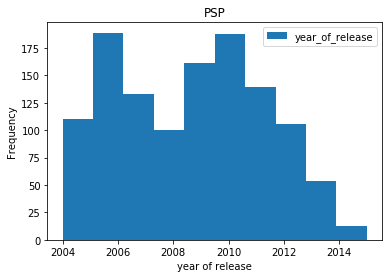

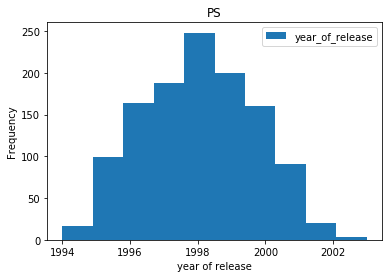

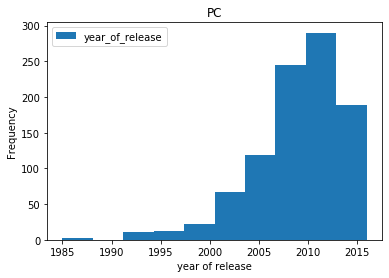

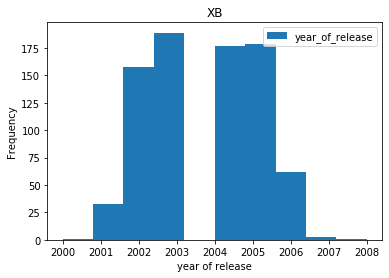

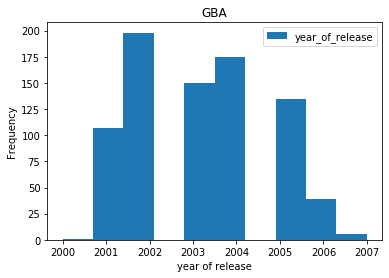

In [14]:
# функция построения гистограммы распределения по годам релизов популярных платформ
def platform_plot_hist(platform_name):
    data[data['platform'] == platform_name].plot(y='year_of_release', kind='hist', title=platform_name).set_xlabel('year of release')

# распределение по годам релизов 10 популярных платформ
for i in range(0, 10):
    platform_plot_hist(popular_platform_amount.index[i])

Характерный срок жизни платформы около 9-11 лет. Исходя из этого, чтобы анализировать актуальные платформы, далее будут проанализированы данные за последние 5 лет (начиная с 2011 года). Введем для этого переменную cut_of_year и сформируем новую базу данных, которая будет содержать в себе данные после 2010 года

In [15]:
cut_of_year = 2010
data_cut_of_year = copy.deepcopy(data[data['year_of_release'] > cut_of_year])

[К оглавлению](#content)

<a id='2-3'></a>
### Анализ платформ лидеров продаж

In [16]:
# какие платформы лидируют по продажам за последние 5 лет
popular_platform_sales = data_cut_of_year.groupby('platform')['total_sales'].sum().sort_values(ascending = False).head(10)
popular_platform_sales

platform
PS3     445.57
X360    380.38
PS4     314.14
3DS     257.81
XOne    159.32
PC       97.68
Wii      95.02
WiiU     82.19
PSV      53.81
DS       38.73
Name: total_sales, dtype: float64

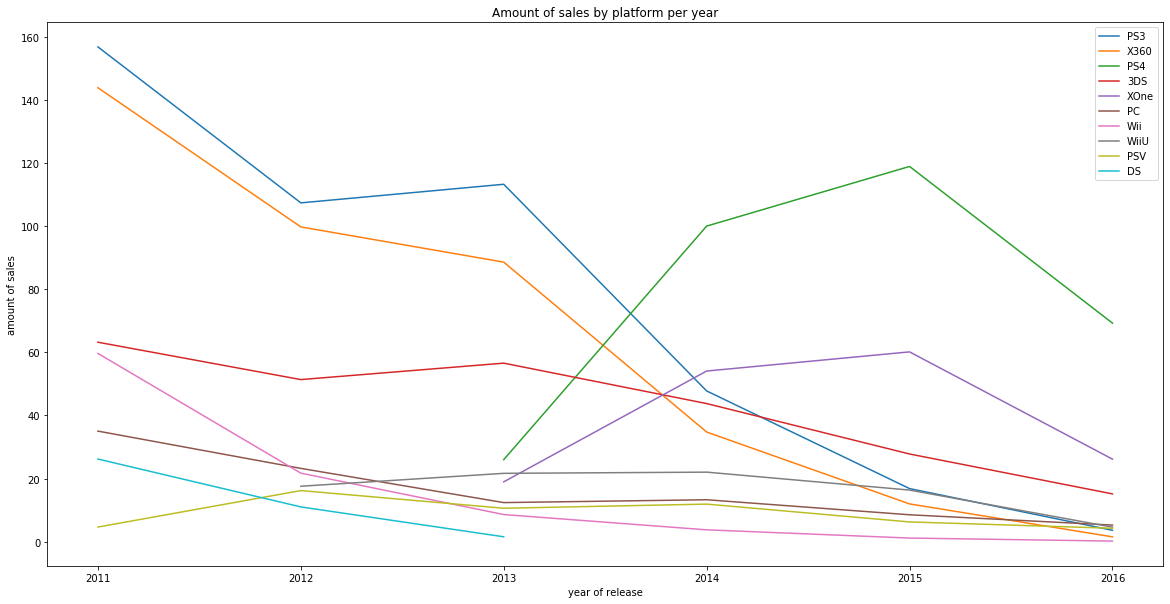

In [17]:
# функция построения динамики продаж по годам
def platform_sales_dynamics(platform, ax):
    x = data_cut_of_year[data_cut_of_year['platform'] == platform].groupby('year_of_release')['total_sales'].sum().index
    y = data_cut_of_year[data_cut_of_year['platform'] == platform].groupby('year_of_release')['total_sales'].sum()
    ax.plot(x, y, label = platform)
    ax.legend()
    ax.set_ylabel('amount of sales')
    ax.set_xlabel('year of release')

# построение графика динамики продаж по платформам
fig, ax = plt.subplots()
ax.set_title('Amount of sales by platform per year')
fig.set_figwidth(20)
fig.set_figheight(10)

for i in range(len(popular_platform_sales)):
    platform_sales_dynamics(popular_platform_sales.index[i], ax)

Поскольку данные за 2016 год не полные, проанализируем продажи до 2015 года включительно. Платформы с наибольшим количеством продаж на 2015 год с восходящим трендом - PS4 и XOne. На третьем месте платформа 3DS, однако у нее нисходящий тренд, начиная с 2013 года

PS3        total_sales
count     6.000000
mean     74.261667
std      60.695667
min       3.600000
25%      24.555000
50%      77.560000
75%     111.777500
max     156.780000
X360        total_sales
count     6.000000
mean     63.396667
std      56.074638
min       1.520000
25%      17.655000
50%      61.660000
75%      96.950000
max     143.840000
PS4        total_sales
count     4.000000
mean     78.535000
std      40.567917
min      25.990000
25%      58.435000
50%      84.625000
75%     104.725000
max     118.900000
3DS        total_sales
count     6.000000
mean     42.968333
std      18.278261
min      15.140000
25%      31.775000
50%      47.560000
75%      55.267500
max      63.200000
XOne        total_sales
count     4.000000
mean     39.830000
std      20.313977
min      18.960000
25%      24.352500
50%      40.110000
75%      55.587500
max      60.140000


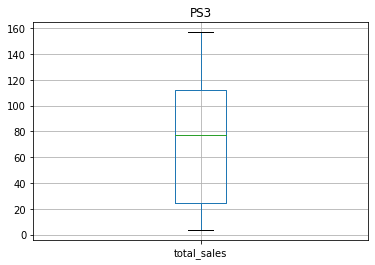

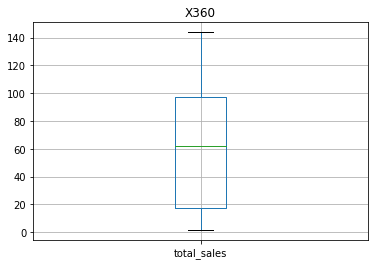

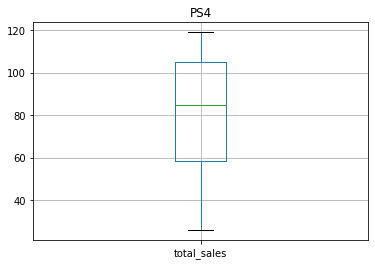

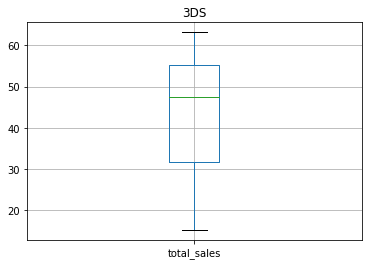

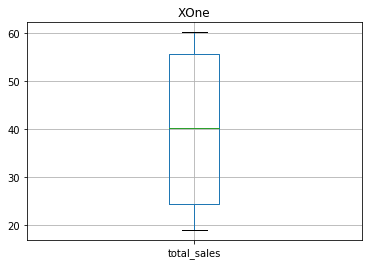

In [18]:
# построение ящика с усами для топ 5 платфор по прибыли за последние 5 лет
# функция построения ящика с усами и вывода описательной статистики
def platform_plot_box(platform_name):
    (data_cut_of_year
     .query('platform == @platform_name')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='box', title=platform_name, grid=True)
    )
    print(platform_name, data_cut_of_year
     .query('platform == @platform_name')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .describe()
    )

# построение ящиков с усами и описательная статистика по продажам по годам для топ 5 платформ по прибыли
for i in range(0, 5):
    platform_plot_box(popular_platform_sales.index[i])

Медианы продаж за последние 5 лет по платформам и 95% CI: PS3 - 78 (CI 5-155), X360 - 62 (CI 5-145), PS4 - 85 (CI 10-120), 3DS - 48 (CI 5-65), XOne - 40 (CI 15-60)

Наблюдается существенная разница между объемами продаж в тройке лидеров (PS3, X360 и PS4) и остальными платформами

PS3 count    708.000000
mean       0.629336
std        1.451388
min        0.010000
25%        0.070000
50%        0.210000
75%        0.640000
max       21.050000
Name: total_sales, dtype: float64
X360 count    498.000000
mean       0.763815
std        1.637090
min        0.010000
25%        0.090000
50%        0.270000
75%        0.780000
max       16.270000
Name: total_sales, dtype: float64
PS4 count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64
3DS count    512.000000
mean       0.503535
std        1.441271
min        0.010000
25%        0.050000
50%        0.120000
75%        0.332500
max       14.600000
Name: total_sales, dtype: float64
XOne count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64


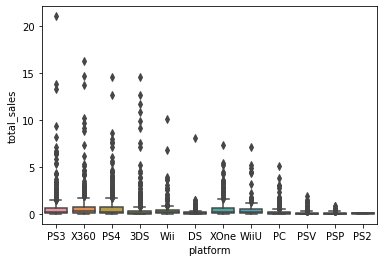

In [19]:
# график без групировки по годам 
ax = sns.boxplot(x="platform", y="total_sales", data=data_cut_of_year)

# описательная статистика для платформ без групировки по годам
def platform_sales_describe(platform_name, data_cut_of_year):
    print(platform_name, data_cut_of_year[data_cut_of_year['platform'] == platform_name]['total_sales'].describe())

# описательная статистика продаж для топ 5 платформ по прибыли
for i in range(0, 5):
    platform_sales_describe(popular_platform_sales.index[i], data_cut_of_year)

Самые продаваемые игры на платформах PS3, X360, PS4 и 3DS. Самая продаваемая за все время игра была на платформе PS3 (21.05 млн копий)

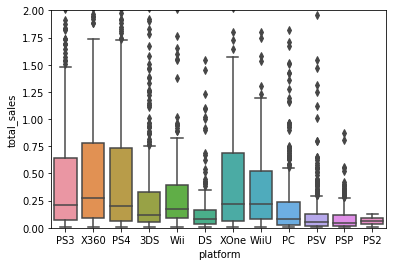

In [20]:
# график без групировки по годам 
plt.ylim(0, 2)
ax = sns.boxplot(x="platform", y="total_sales", data=data_cut_of_year)

Медианы продаж за все время по 5 самым популярным платформам за посление пять лет и 95% CI: 
    
PS3 - 0.21 (CI 0.01 - 1.5)
    
X360 - 0.27 (CI 0.01 - 1.75)
    
PS4 - 0.20 (CI 0.01 - 1.74)
    
3DS - 0.12 (CI 0.01 - 0.75)
    
XOne - 0.22 (CI 0.01 - 1.6)


Изучение влияние на продажи отзывов пользователей и критиков для платформы PS3

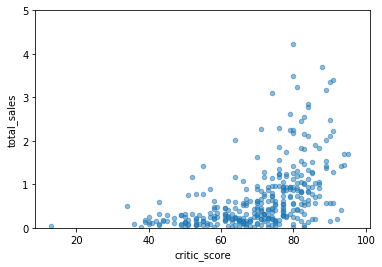

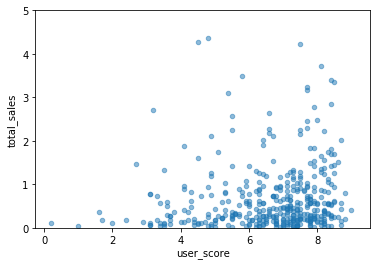

In [21]:
# построение диаграммы рассеивания отзывов и продаж для платформы PS3
data_cut_of_year[data_cut_of_year['platform'] == 'PS3'].plot(x='critic_score', y='total_sales', alpha=0.5, kind='scatter', ylim=(0, 5))
data_cut_of_year[(data_cut_of_year['platform'] == 'PS3')].plot(x='user_score', y='total_sales', alpha=0.5, kind='scatter', ylim=(0, 5))

In [22]:
# расчет корреляции отзывов критиков и продаж для платформы PS3
display(data_cut_of_year[(data_cut_of_year['platform'] == 'PS3')]['critic_score'].corr(data[data['platform'] == 'PS3']['total_sales']))

# расчет корреляции отзывов пользователей и продаж для платформы PS3
display(data_cut_of_year[(data_cut_of_year['platform'] == 'PS3')]['user_score'].corr(data[data['platform'] == 'PS3']['total_sales']))

0.3801111471829076

0.014089348308019396

Имеется средняя положительная корреляция между отзывами критиков и объемом продаж. Нет корреляции между отзывами пользователей и объемами продаж

Ради интереса посмотрим корреляции между отзывами и объемом продаж для всех платформ

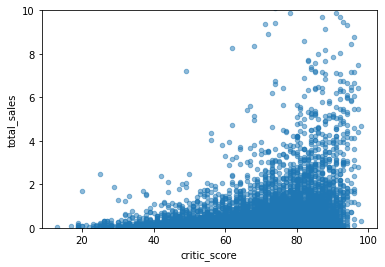

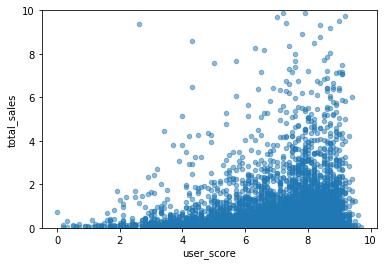

In [23]:
# построение диаграммы рассеивания отзывов и продаж для платформы PS3
data.plot(x='critic_score', y='total_sales', alpha=0.5, kind='scatter', ylim=(0, 10))
data.plot(x='user_score', y='total_sales', alpha=0.5, kind='scatter', ylim=(0, 10))

In [24]:
# расчет корреляции отзывов критиков и продаж для всех платформ за последние пять лет
display(data_cut_of_year['critic_score'].corr(data_cut_of_year['total_sales']))

# расчет корреляции отзывов пользователей и продаж для всех платформ за последние пять лет
display(data_cut_of_year['user_score'].corr(data_cut_of_year['total_sales']))

0.3299765050114585

0.03163612772559288

Так же имеется средняя положительная корреляция между отзывами критиков и объемом продаж. Корреляция между отзывами пользователей и объемами продаж незначительная

Таким обазом, стоит взаимодествовать с критиками и лидерами мнений для продвижения новой игры

In [25]:
# распределение продаж по жанрам в целом
display(data.groupby('genre')['total_sales'].sum().sort_values(ascending = False))

# распределение продаж по жанрам за последние пять лет
display(data_cut_of_year.groupby('genre')['total_sales'].sum().sort_values(ascending = False))

genre
Action          1744.17
Sports          1331.27
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: total_sales, dtype: float64

genre
Action          557.80
Shooter         402.91
Role-Playing    245.63
Sports          237.15
Misc            139.42
Platform         88.68
Racing           88.31
Fighting         66.90
Simulation       50.26
Adventure        45.04
Strategy         22.16
Puzzle            9.85
Name: total_sales, dtype: float64

Самыми продаваемыми жанрами за последние пять лет явлются Action, Shooter и Role-Playing, что совпадает с самыми продаваемыми жанрами за все года. Самыми не продаваемыми жанрами являются Adventure, Strategy и Puzzle

Расчет количества игр в каждом жанре

In [26]:
# количество игр в каждом жанре
data_cut_of_year.groupby('genre')['genre'].count().sort_values(ascending = False)

genre
Action          1269
Role-Playing     465
Adventure        410
Sports           389
Misc             375
Shooter          329
Racing           180
Fighting         159
Simulation       136
Platform         122
Strategy         117
Puzzle            71
Name: genre, dtype: int64

In [27]:
# количество игр сильно различается
# расчет медианны продаж игр по жанрам
data_cut_of_year.groupby('genre')['total_sales'].median().sort_values(ascending = False)

genre
Shooter         0.410
Sports          0.200
Platform        0.185
Fighting        0.180
Racing          0.160
Role-Playing    0.150
Misc            0.130
Action          0.130
Simulation      0.110
Strategy        0.080
Puzzle          0.050
Adventure       0.030
Name: total_sales, dtype: float64

Самые большие медианы продаж у жанров Shooter (0.41), Sports (0.2) и Platform (0.185)
    
Самые низкие медианы продаж у жанров Strategy (0.08), Puzzle (0.05) и Adventure (0.03)

[К оглавлению](#content)

<a id='3'></a>
## Портрет пользователя каждого региона

[К оглавлению](#content)

<a id='3-1'></a>
### Топ 5 платформ по регионам

In [28]:
def top_region_func(region, parameter):
    result = data_cut_of_year.groupby(parameter)[region].sum().sort_values(ascending=False).head()
    return result

# регион NA
top_region_func('na_sales','platform')

platform
X360    226.80
PS3     168.26
PS4     108.74
XOne     93.12
3DS      82.65
Name: na_sales, dtype: float64

In [29]:
# регион EU 
top_region_func('eu_sales','platform')

platform
PS3     163.10
PS4     141.09
X360    117.10
3DS      61.27
PC       56.70
Name: eu_sales, dtype: float64

In [30]:
# регион JP
top_region_func('jp_sales','platform')

platform
3DS    100.62
PS3     49.39
PSP     24.04
PSV     21.84
PS4     15.96
Name: jp_sales, dtype: float64

В регионах разные топ 5 по продажам платформы за последние 5 лет. В NA с большим отрывом лидирует платформа X360 и при этом она не входит в топ платформ в JP. В рейтинге топ 5 платформ во всех регионах присутствуют PS3, PS4 и 3DS 

Расчет доли продаж каждой платформы от общих продаж в регионе

In [31]:
# доля продаж каждой платформ от общих продаж в регионе
def platform_totalsales_func(region, parameter):
    result = (data_cut_of_year.groupby(parameter)[region].sum() * 100 
              / data_cut_of_year[region].sum()).sort_values(ascending=False).head()
    return result

# регион NA
platform_totalsales_func('na_sales','platform')

platform
X360    27.333205
PS3     20.278153
PS4     13.104994
XOne    11.222522
3DS      9.960712
Name: na_sales, dtype: float64

In [32]:
# регион EU
platform_totalsales_func('eu_sales','platform')

platform
PS3     24.350916
PS4     21.064811
X360    17.483092
3DS      9.147643
PC       8.465340
Name: eu_sales, dtype: float64

In [33]:
# регион JP
platform_totalsales_func('jp_sales','platform')

platform
3DS    40.960716
PS3    20.105842
PSP     9.786281
PSV     8.890698
PS4     6.497049
Name: jp_sales, dtype: float64

В регионах разные относительные объемы продаж игр по платформам. В NA это X360 (27%), в EU - PS3 (24%), в JP - 3DS (41%). Продажи игр на на самых популярных платформах в NA и EU соcтавляют менее трети объема продаж, продажи игр на самой популярной патформе в JP при этом более 40% от суммарного объема продаж по региону.
    

Относительный объем продаж игр на PS3 во всех регионах примерно одинаковый  - немногим больше 20%
    
Самый большой относительный объем продаж игр на PS4 в EU

[К оглавлению](#content)

<a id='3-2'></a>
### Топ 5 популярных жанров по регионам 

In [34]:
# регион NA
top_region_func('na_sales', 'genre')

genre
Action          230.92
Shooter         194.43
Sports          108.70
Role-Playing     83.78
Misc             69.69
Name: na_sales, dtype: float64

In [35]:
# регион EU 
top_region_func('eu_sales', 'genre')

genre
Action          199.12
Shooter         148.02
Sports           88.48
Role-Playing     62.30
Racing           40.58
Name: eu_sales, dtype: float64

In [36]:
# регион JP
top_region_func('jp_sales', 'genre')

genre
Role-Playing    79.87
Action          63.62
Misc            17.60
Fighting        12.38
Platform        12.13
Name: jp_sales, dtype: float64

В NA и EU совпадают топ 4 самых продаваемых жанра (Action, Shooter, Sports, Role-Playing). В регионе JP самые продаваемые жанры Role-Playing и Action, с большим отрывом от остальных жанров. Во всех регионах в топ 5 входят жанры Action и Role-Playing. Можно сказать, что Action самый популярный жанр за последние пять лет в целом по регионам

[К оглавлению](#content)

<a id='3-3'></a>
### Анализ связи рейтинга ESRB и продаж в регионах

In [37]:
# заменим пропущенные значения на 'WR' (without rating)
data_cut_of_year['rating'] = data_cut_of_year['rating'].fillna('WR')

# изучим рейтинги
def ESRB_sales_region(region):
    print(data_cut_of_year.groupby('rating')[region].sum()
          .sort_values() * 100 / sum(data_cut_of_year[region]))

In [38]:
# продажи в зависимости от рейтинга в NA в %
ESRB_sales_region('na_sales')

rating
RP       0.000000
EC       0.050617
T       13.173689
E10+    14.187235
WR      14.906720
E       20.508340
M       37.173400
Name: na_sales, dtype: float64


In [39]:
# продажи в зависимости от рейтинга в EU в %
ESRB_sales_region('eu_sales')

rating
EC       0.000000
RP       0.004479
E10+    11.645441
T       12.415832
WR      17.409934
E       21.160364
M       37.363950
Name: eu_sales, dtype: float64


In [40]:
# продажи в зависимости от рейтинга в JP в %
ESRB_sales_region('jp_sales')

rating
EC       0.000000
RP       0.000000
E10+     4.571545
M       10.641156
T       13.592510
E       14.931814
WR      56.262976
Name: jp_sales, dtype: float64


В NA и EU больше всего продаются игры с рейтингами M и E - более половины всех продаж. В JP больше половины проданных игр не имеют рейтинга, а самые продаваемые рейтинги E и T, чуть хуже продаются игры с ретингом M. Во всех регионах меньше всего продаются игры с рейтингом EC.

Рейтинг ESRB плохо подходит для анализа рынка Японии, так как ориентирован на Америку, а в Японии есть свои особенности. Возможно стоит найти локальный возрастной рейтинг для анализа рынка Азии.

[К оглавлению](#content)

<a id='4'></a>
## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза: средние пользовательские рейтинги не одинаковые

Проверка гипотезы будет производиться t-критерием Стьюдента, уровень значимости примем 0.05

In [41]:
# проеврка гипотезы
results = st.ttest_ind(data_cut_of_year[data_cut_of_year['platform'] == 'XOne']['user_score'], 
                      data_cut_of_year[data_cut_of_year['platform'] == 'PC']['user_score'], 
                      equal_var=False, nan_policy='omit')

display('p-value', results.pvalue)

'p-value'

0.6130712247637622

p-value > 0.05, принимаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

Проверка гипотезы будет производиться t-критерием Стьюдента, уровень значимости примем 0.05

In [42]:
# проверка гипотезы
results = st.ttest_ind(data_cut_of_year[data_cut_of_year['genre'] == 'Action']['user_score'], 
                      data_cut_of_year[data_cut_of_year['genre'] == 'Sports']['user_score'], 
                      equal_var=False, nan_policy='omit')

display('p-value', results.pvalue)
display(data_cut_of_year[data_cut_of_year['genre'] == 'Action']['user_score'].mean())
display(data_cut_of_year[data_cut_of_year['genre'] == 'Sports']['user_score'].mean())

'p-value'

8.285648549430888e-19

6.775903614457831

5.650813008130081

p-value < 0.05, принимаем альтернативную гипотезу: средний пользовательский рейтинг жанра Action выше чем средний пользовательский рейтинг жанра Sports

[К оглавлению](#content)

<a id='outcome'></a>
## Вывод

Были изучены и предобработаны исходные данные. В данных наблюдаются пропущенные значения, в рейтинге пользователей встречается значение 'tbd'. Стоит поговорить с коллегами, выдавшими данные, о возможности восстановления пропущенных значений и рейтингов 

 - Характерный **срок жизни платформы около 9-11 лет**.

 - В целом на текущий момент по всем регионам самые продаваемые платформы PS3, X360 и PS4, самые продаваемые жанры Action, Shooter и Role-Playing. Хуже всего продаются жанры Adventure, Strategy и Puzzle

 - Самые продаваемые платформы различны в регионах: в NA с большим отрывом лидирует платформа X360 и при этом она не входит в топ платформ в JP. В рейтинге топ 5 платформ во всех регионах присутствуют PS3, PS4 и 3DS. Самые продаваемые игры на платформах PS3, X360, PS4 и 3DS. Самая продаваемая за все время игра была на платформе PS3. В регионах разные относительные объемы продаж игр по платформам. В NA это X360 (27%), в EU - PS3 (24%), в JP - 3DS (41%). Относительный объем продаж игр на PS3 во всех регионах примерно одинаковый  - немногим больше 20%. Самый большой относительный объем продаж игр на PS4 в EU. Самый большой относительный объем продаж игр на XOne в NA 

 - В NA и EU совпадают топ 4 самых продаваемых жанров: Action, Shooter, Sports и Role-Playing. В JP самые продаваемые жанры Role-Playing и Action, с большим отрывом от остальных жанров. Во всех регионах в топ 5 входят жанры Action и Role-Playing. Можно сказать, что **Action самый популярный жанр за последние пять лет в целом по регионам.** Самые большие медианы продаж у жанров Shooter, Sports и Platform, самые низкие медианы продаж у жанров Strategy, Puzzle и Adventure.

 - В NA и EU больше всего продаются игры с рейтингами M и E - более половины всех продаж. В JP больше половины проданных игр не имеют рейтинга. Во всех регионах меньше всего продаются игры с рейтингом EC. У Xbox One и PC одинаковые средние пользовательские рейтинги. У жанра Action выше средние пользовательские рейтинги, чем у жанра Sports

 - **платформы с наибольшим количеством продаж по данным 2015 года и с восходящим трендом - PS4 и XOne**. На третьем месте по объему продаж платформа 3DS, однако у нее нисходящий тренд    
       


[К оглавлению](#content)